In [2]:
from stable_baselines3 import PPO
from CavityQubitEnv import CavityQubitEnv
import os
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
import torch.nn as nn  # Import PyTorch for activation functions
from stable_baselines3.common.env_util import make_vec_env
%matplotlib widget
# Wrap environment with Monitor for logging
log_dir = "./logs"
os.makedirs(log_dir, exist_ok=True)
# env = Monitor(PiPulseEnv(), log_dir)
# autoreload the environment if it changes
%load_ext autoreload
%autoreload 2

pulse_dir = "./pulses"
os.makedirs(pulse_dir, exist_ok=True)



# Load the pulse parameters

KeysView(NpzFile './pulses\\pulse_fock_0+2i.npz' with keys: I_q, Q_c, Q_q, times, chi...)


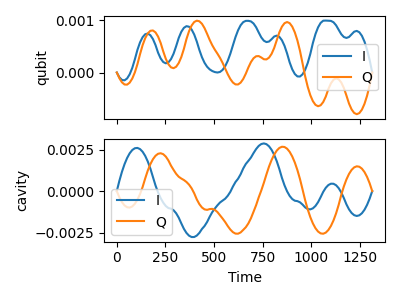

In [ ]:
pulse_name = 'pulse_fock_0+2i.npz'
N_points = 30 # number of control points for each control ( it is to downsample the original pulse if needed, using cubic splines)
nb_sample = None # number of sample to take for the wigner, if None rewards is computed on the full state
model_name = 'model_' + pulse_name.split('.')[0]
# open the pulse file
pulse_data = np.load(os.path.join(pulse_dir, pulse_name), allow_pickle=True)
print(pulse_data.keys())

_psi_0 = pulse_data['psi_0']
_psi_target = pulse_data['psi_target']
psi_0 = _psi_0[:len(_psi_0)//2] + 1j * _psi_0[len(_psi_0)//2:]
psi_target = _psi_target[:len(_psi_target)//2] + 1j * _psi_target[len(_psi_target)//2:]
Kc = float(pulse_data['Kc'])
Kq = float(pulse_data['Kq'])
chi = float(pulse_data['chi'])
cutoff_qubit = int(pulse_data['cutoff_qubit'])
cutoff_cavity = int(pulse_data['cutoff_cavity'])
psi_0 = qt.Qobj(psi_0, dims=[[cutoff_qubit, cutoff_cavity], [1]])
psi_target = qt.Qobj(psi_target, dims=[[cutoff_qubit, cutoff_cavity], [1]])

# define the system deviation 


system_params = {
    'cutoff_qubit': cutoff_qubit,
    'cutoff_cavity': cutoff_cavity,
    'Kc': Kc*0.90,
    'Kq': Kq*0.90,
    'chi': chi*1.15 
}


Iq = pulse_data['I_q']
Qq = pulse_data['Q_q']
Ic = pulse_data['I_c']
Qc = pulse_data['Q_c']
times = pulse_data['times']
pulse_IQ = {
    'Iq': Iq,
    'Qq': Qq,
    'Ic': Ic,
    'Qc': Qc,
    'times': times
}
amplitude_bound_qb = max(np.max(np.abs(Iq)), np.max(np.abs(Qq)))*0.1 # how much tunning is allowed
amplitude_bound_cav = max(np.max(np.abs(Ic)), np.max(np.abs(Qc)))*0.1
amplitude_bounds = [amplitude_bound_qb, amplitude_bound_cav]

fig, ax = plt.subplots(2, 1, figsize=(4, 3), sharex=True)
ax[0].plot(times, Iq, label='I')
ax[0].plot(times, Qq, label='Q')
ax[0].set_ylabel('qubit')
ax[0].legend()
ax[1].plot(times, Ic, label='I')
ax[1].plot(times, Qc, label='Q')
ax[1].set_ylabel('cavity')
ax[1].set_xlabel('Time')
ax[1].legend()
fig.tight_layout()


# Set up the model 

This can be run to tests the action before training

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\slab\.conda\envs\sb3_gpu\lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Episode 0 reward: 0.4673026563106552


c:\Users\slab\Documents\seb\Stable baselines\CavityQubitEnv.py:350: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


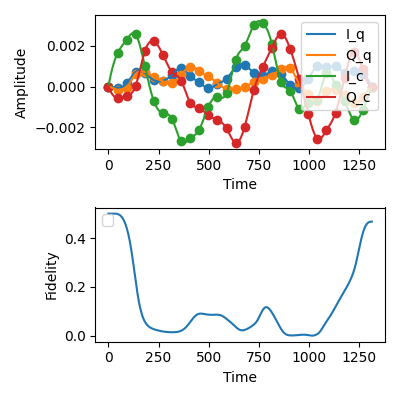

In [4]:
env = CavityQubitEnv(
    psi_0=psi_0,
    psi_target=psi_target,
    system_params=system_params,
    pulse_IQ=pulse_IQ,
    amplitude_bounds=amplitude_bounds,
    N_points=N_points,
    nb_sample=nb_sample
)
model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    tensorboard_log="./tensorboard_logs",
)

for ep in range(1):
    obs, _ = env.reset()   # unpack tuple
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"Episode {ep} reward: {reward}")
    env.render()

Trainings happens here

In [8]:
env = CavityQubitEnv(
    psi_0=psi_0,
    psi_target=psi_target,
    system_params=system_params,
    pulse_IQ=pulse_IQ, 
    amplitude_bounds=amplitude_bounds,
    nb_sample=nb_sample,
    N_points=N_points
)
# vec_env = make_vec_env(lambda: env, n_envs=1)
eval_callback = EvalCallback(
    env,
    best_model_save_path=log_dir,
    log_path=log_dir,
    eval_freq=250,
    deterministic=True,
    render=False
)

# Policy architecture
policy_kwargs = dict(
    net_arch=[dict(pi=[50, 20], vf=[])],  # actor and value net separately
    log_std_init=np.log(0.08)             # initialize policy std
)

model = PPO(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=1e-3,
    n_epochs=20,            # num_policy_updates
    batch_size=50,          # train_batch_size
    n_steps=50,             # episodes per batch × episode length
    gamma=1.0,
    clip_range=0.5,
    ent_coef=0.0,
    vf_coef=0.005,
    max_grad_norm=1.0,
    tensorboard_log="logs",
    policy_kwargs=policy_kwargs,
    device="cpu"
)

total_timesteps = 100 * 50   # = 5000 if ep_length=1
model.learn(total_timesteps=total_timesteps, callback=eval_callback)
model.save(model_name)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\PPO_1


c:\Users\slab\.conda\envs\sb3_gpu\lib\site-packages\stable_baselines3\common\policies.py:486: UserWarning: As shared layers in the mlp_extractor are removed since SB3 v1.8.0, you should now pass directly a dictionary and not a list (net_arch=dict(pi=..., vf=...) instead of net_arch=[dict(pi=..., vf=...)])
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.844    |
| time/              |          |
|    fps             | 36       |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 50       |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 1         |
|    ep_rew_mean          | 0.851     |
| time/                   |           |
|    fps                  | 36        |
|    iterations           | 2         |
|    time_elapsed         | 2         |
|    total_timesteps      | 100       |
| train/                  |           |
|    approx_kl            | 3.4504824 |
|    clip_fraction        | 0.788     |
|    clip_range           | 0.5       |
|    entropy_loss         | 124       |
|    explained_variance   | 0         |
|    learning_rate        | 0.001     |
|    loss           

Look at the fidelity per episode

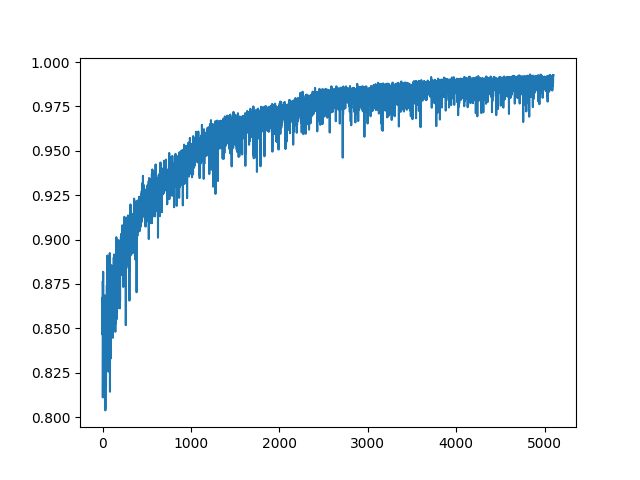

In [9]:
fig, ax = plt.subplots()
ax.plot(env.fid_list)

Training more if needed

In [7]:
model = PPO.load(model_name, env=env, device="cpu")
model.learn(total_timesteps=total_timesteps, callback=eval_callback, reset_num_timesteps=False)
model.save(model_name)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to logs\PPO_23
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.882    |
| time/              |          |
|    fps             | 37       |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 5050     |
---------------------------------


KeyboardInterrupt: 

Check the action after training 

Episode 0 reward: 0.9925820316844324


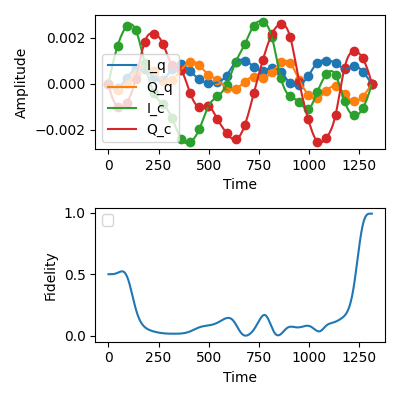

In [10]:
for ep in range(1):
    obs, _ = env.reset()   # unpack tuple
    # obs = vec_env.reset()   # unpack tuple
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    print(f"Episode {ep} reward: {reward}")
    env.render()
